In [ ]:
!pip install --upgrade pandas

In [1]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


TFIDF_ITEMS=20 #Number of items to retrieve by tf-idf
MAX_ITEMS=5 #Number of ranked items to be returned, changeable :-)
PASSAGES=4000 #Number of passages used , fixed :-(
QUERIES=280 #Number of queries made against these passages, fixed :-(

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [2]:
filepath='/content/drive/MyDrive/Zevi_search_dataset.json'

with open(filepath) as f:
  data = json.load(f)
df=pd.DataFrame(data)


In [3]:
#Select part of dataframe because of limited resources
samples=9000
dfs=df.sample(frac=0.25,random_state=1,ignore_index=True)
dfs.head()

name  ... objectID
0  Vornado - VFAN Sr. Pedestal Vintage Circulator...  ...  5064622
1  KitchenAid - 36" Externally Vented Range Hood ...  ...  2507163
2  Native Union - Clic 360 Case for Apple® iPhone...  ...  5549400
3  BLU - Dash L2 D250U GSM 4G Cell Phone (Unlocke...  ...  5322500
4  Nostalgia Electrics - Retro Series 0.7 Cu. Ft....  ...  2672715

[5 rows x 14 columns]

## EDA
 Analyzing the distributions of numerical and counts of categorical features. Except for image and object Id colums.

In [5]:
dfs.columns

Index(['name', 'description', 'brand', 'categories', 'hierarchicalCategories',
       'type', 'price', 'price_range', 'image', 'url', 'free_shipping',
       'rating', 'popularity', 'objectID'],
      dtype='object')

In [6]:
dfs.loc[932,['name','brand']]

name     Peerless - SmartMount Tilt TV Wall Mount for M...
brand                                             Peerless
Name: 932, dtype: object

**Analysis**
Name of the brand is concatenated with the name of the product with a trailing dash, and for now we will keep both brand name field seperately and brand appended with product name.

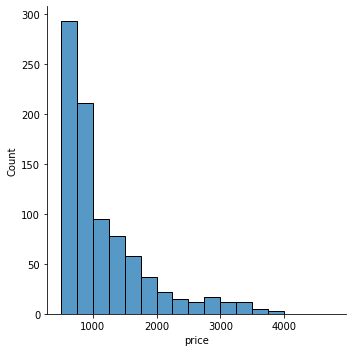

In [7]:
#Get distribution of price of products
sns.displot(dfs, x='price',bins=list(np.arange(500,5000,250)));


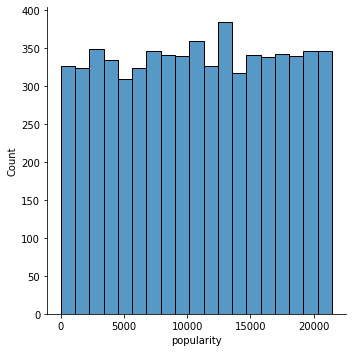

In [8]:
#Get distribution of popularity of products
sns.displot(dfs, x='popularity');


The popularity feature is simply incremental for each product, where the first product has highest value for popularity i.e. number of products and the last product has least value of popularity i.e. 1. We are gonna encode this feature as a sentence too, for answering queries relevant to order of items / popularity in data.

In [9]:
dfs['price_range'].unique()

array(['100 - 200', '500 - 2000', '1 - 50', '50 - 100', '200 - 500',
       '> 2000'], dtype=object)

**Analysis**
Price Range seems to be not much of a useful feature, as the exact price is already given, but we are gonna encode exact price information and price range into a single sentence for the passage.

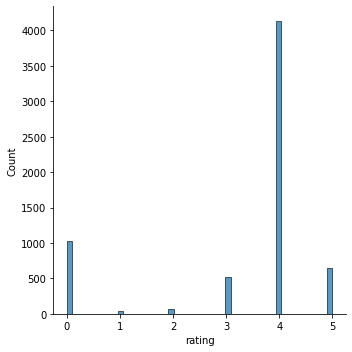

In [10]:
#Get distribution of rating of products
sns.displot(dfs, x='rating');


**Analysis**
Most of the products are ranked at a rating of 4, whereas very few products have a rating less than 3. Ratings can help answer queries including the information about the sentiment of the user towards product. Each rating value can be associated with an ordinal sentiment category.

In [11]:
x=dfs['brand'].value_counts()

In [12]:
brand_df=pd.DataFrame(dfs.loc[x[x>300],'brand'],columns=['brand'])
sns.catplot(x="brand", kind="count", palette="ch:.25", data=brand_df);


ValueError: ignored

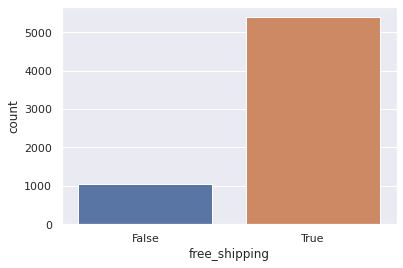

In [13]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="free_shipping", data=dfs)

In [14]:
#Percent of products with free shipping
dfs.loc[df['free_shipping']==True,'free_shipping'].count()/dfs.shape[0]

0.8073280546498991

**Analysis**
Almost 83% products have free shipping and remaining have shiiping charges. Query involving free shipping requests can help filter these products, if I include free_shipping as a sentence in passage.

In [17]:
dfs.iloc[30,'hierarchicalCategories']

KeyError: ignored

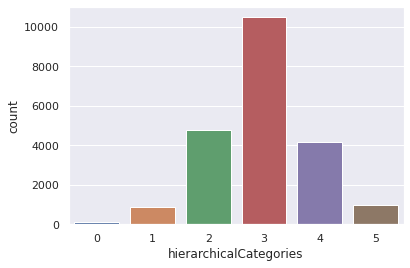

In [34]:
category_lengths=pd.DataFrame(df['hierarchicalCategories'].apply(lambda x: len(x)))
ax = sns.countplot(x="hierarchicalCategories", data=category_lengths)

**Analysis**
Each heirarchichal category have atmost three levels of categories it belongs to, where ever preeceding level is a sub level of the previous category. Most of the products have 3 categorical levels, whereas last categorical level contains infor about all the levels and hence can be used for encoding information about heirarchical categoires in passage.

In [35]:
df['categories'][13]

['TV & Home Theater', 'TV Mounts']

In [36]:
df['hierarchicalCategories'][13]

{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Home Theater > TV Mounts'}

**Analysis**
We will encode information from heirarchical categories into a passage from last level, as it encodes information about order and related categoires of a product.


In [37]:
df.columns

Index(['name', 'description', 'brand', 'categories', 'hierarchicalCategories',
       'type', 'price', 'price_range', 'image', 'url', 'free_shipping',
       'rating', 'popularity', 'objectID'],
      dtype='object')

In [38]:
#Missing Values
df.isnull().sum()

name                      0
description               0
brand                     0
categories                0
hierarchicalCategories    0
type                      0
price                     0
price_range               0
image                     0
url                       1
free_shipping             0
rating                    0
popularity                0
objectID                  0
dtype: int64

In [39]:
df.loc[df['url'].isnull(),'url']='<NoURL>'


In [40]:
#Missing Values
df.isnull().sum()

name                      0
description               0
brand                     0
categories                0
hierarchicalCategories    0
type                      0
price                     0
price_range               0
image                     0
url                       0
free_shipping             0
rating                    0
popularity                0
objectID                  0
dtype: int64

**Analysis**
There are no missing vlaues in this dataframe execpt for one sample's url, which is great.

**Conclusion EDA**

There is alot of other questoins that can be asked form data, but contextual encoding of the passage and query is expected to answer all those questions automatically, while attention based searching. Some of the questions include:
1. What are the products one can get from a particular category in given price range with free shipping?
2. What is the price range of top rated products? What are the cheapest top rated products?
3. Which category have largest description?
4. What is the difference between price of products with free shipping  and shipping charges?
5. For a particular category which brands offers the cheapest top rated products?


## Data Preprocessing
For treating this problem as an open ended contextual QnA problem, we need to transform each sample into a document index aka a passage and append it to description. 


### **Passage Creation**
For that we transform each feature or attribute into a sentence, except for object Id and missing features.
All features seems good candidate for feature creation. We are not dropping the url, objectID and popularity column either and including it as a sentence in the passage, for answering the queries related to these features.


In [4]:
dfs.columns

Index(['name', 'description', 'brand', 'categories', 'hierarchicalCategories',
       'type', 'price', 'price_range', 'image', 'url', 'free_shipping',
       'rating', 'popularity', 'objectID'],
      dtype='object')

In [5]:
#Function for converting each record to a passage.
#Args: One record from dataframe df.iloc[0]
#Returns:  Passage corresponding to input record
def make_passage(product):
  #Result passage object to return
  psg=''

  #Trsform name column to sentence
  psg+='The product is called '+product['name']+'.'

  #Brand
  psg+='It is made by '+product['brand']+'. '

  #Append description to it
  psg+=product['description']

  #Append type
  if product['type']:
    psg+='It is a '+product['type']+'. '

  #Append price and price range
  psg+='It falls in price range of '+ str(product['price_range']) + ' and is of '+ str(product['price'])+ ' dollars.'

  #Append heirarchical category
  if(len(product['hierarchicalCategories'])>0):
    cat_lvls=product['hierarchicalCategories'][list(product['hierarchicalCategories'])[-1]].split('>')
    psg+='It belongs to '+cat_lvls[0]
    for lvl in cat_lvls[1:]:
      psg+=' and it\'s sub category '+lvl

  #Free shipping
  if product['free_shipping']:
    psg+='. It has free shipping.'
  else:
    psg+='. It does not have free shipping.'
  
  #Rating and popularity
  psg+='It has a rating of '+ str(product['rating'])+' and a popularity index of '+str(product['popularity'])+'.'

  #Object Id
  psg+=' The object id of the product is '+product['objectID']+'.' 

  #Product id, url and image
  if product['image']:
    psg+='Image is avaible on '+product['image']
  
  #Append product url
  if product['url']:
    psg+=' and more detials can be found on '+product['url'] +'.'

  return psg


In [6]:
make_passage(dfs.iloc[0])

"The product is called Vornado - VFAN Sr. Pedestal Vintage Circulator Fan - Green.It is made by Vornado. Enjoy classic styling and modern technology with this Vornado VFAN pedestal air circulator. This fan features metal construction that won't rust while it provides a retro look. This Vornado VFAN pedestal air circulator has a fully pivoting head to move air around a room and three speed settings to choose from.It falls in price range of 100 - 200 and is of 199.99 dollars.It belongs to Appliances  and it's sub category  Fans  and it's sub category  Table & Portable Fans. It has free shipping.It has a rating of 5 and a popularity index of 10212. The object id of the product is 5064622.Image is avaible on https://cdn-demo.algolia.com/bestbuy-0118/5064622_sb.jpg and more detials can be found on https://api.bestbuy.com/click/-/5064622/pdp."

In [7]:
passages=dfs.apply(make_passage,axis=1)
passages.head()

0    The product is called Vornado - VFAN Sr. Pedes...
1    The product is called KitchenAid - 36" Externa...
2    The product is called Native Union - Clic 360 ...
3    The product is called BLU - Dash L2 D250U GSM ...
4    The product is called Nostalgia Electrics - Re...
dtype: object

In [8]:
passages[0]

"The product is called Vornado - VFAN Sr. Pedestal Vintage Circulator Fan - Green.It is made by Vornado. Enjoy classic styling and modern technology with this Vornado VFAN pedestal air circulator. This fan features metal construction that won't rust while it provides a retro look. This Vornado VFAN pedestal air circulator has a fully pivoting head to move air around a room and three speed settings to choose from.It falls in price range of 100 - 200 and is of 199.99 dollars.It belongs to Appliances  and it's sub category  Fans  and it's sub category  Table & Portable Fans. It has free shipping.It has a rating of 5 and a popularity index of 10212. The object id of the product is 5064622.Image is avaible on https://cdn-demo.algolia.com/bestbuy-0118/5064622_sb.jpg and more detials can be found on https://api.bestbuy.com/click/-/5064622/pdp."

### **Query Creation**
Next up we need to create some queries, to deal with it as a supervised learning problem. Using the structure of information retrieval data from Kaggle by the Allen Institute of A.I, [linked here](https://www.kaggle.com/dmaso01dsta/cisi-a-dataset-for-information-retrieval?select=CISI.REL). We can create a couple of test queries to evaluate the performace of the attention based information retreival approach.

In [9]:
#Sample query for Proof Of Concept
query="Bluetooth headphones with active noise cancellation and great battery life,free shipping and under 80 dollars, with above 3 ratings."
print(query)

Bluetooth headphones with active noise cancellation and great battery life,free shipping and under 80 dollars, with above 3 ratings.


# Information Retrieval PipeLine
The pipeline for information retrieval or retrieval of documents/products, given a query involves a series of steps, explained below.


## TF-IDF Retireval
We first retreive the top K passages from the given set of passages, based on a given query and then perform remaining attention based contextual pipeline steps to shortlist products from these retrieved passages.

In [12]:
#Make one string out of all passages
all_passages=''
for psg in passages:
  all_passages+=psg+' .'
all_passages

'The product is called Vornado - VFAN Sr. Pedestal Vintage Circulator Fan - Green.It is made by Vornado. Enjoy classic styling and modern technology with this Vornado VFAN pedestal air circulator. This fan features metal construction that won\'t rust while it provides a retro look. This Vornado VFAN pedestal air circulator has a fully pivoting head to move air around a room and three speed settings to choose from.It falls in price range of 100 - 200 and is of 199.99 dollars.It belongs to Appliances  and it\'s sub category  Fans  and it\'s sub category  Table & Portable Fans. It has free shipping.It has a rating of 5 and a popularity index of 10212. The object id of the product is 5064622.Image is avaible on https://cdn-demo.algolia.com/bestbuy-0118/5064622_sb.jpg and more detials can be found on https://api.bestbuy.com/click/-/5064622/pdp. .The product is called KitchenAid - 36" Externally Vented Range Hood - Stainless Steel.It is made by KitchenAid. Remove smoke and cooking odors from

In [14]:
#Split passage and query into words and get unique words
passage_words=list(set(all_passages.split(' ')))
query_words=list(set(query.split(' ')))
print("Unique Passage Words:",len(passage_words))
print("Unique query Words:",len(query_words))

Unique Passage Words: 51354
Unique query Words: 17


In [15]:
#Remove stopwords from query and passage

pw2=passage_words.copy()
qw2=query_words.copy()
for word in stopwords.words('english'):
  if word in pw2:
    pw2.remove(word)
  if word in qw2:
    qw2.remove(word)

print("StopWord free Passage Words:",len(pw2))
print("StopWord free query Words:",len(qw2))

StopWord free Passage Words: 51237
StopWord free query Words: 13


In [16]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(passages)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf = pd.DataFrame(denselist, columns=feature_names)
print(tfidf)

       00  000  00001  000014  00003  ...  zowie  zsrs60bt  zte   zx  épil
0     0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
1     0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
2     0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
3     0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
4     0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
...   ...  ...    ...     ...    ...  ...    ...       ...  ...  ...   ...
5362  0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
5363  0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
5364  0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
5365  0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0
5366  0.0  0.0    0.0     0.0    0.0  ...    0.0       0.0  0.0  0.0   0.0

[5367 rows x 31324 columns]


In [27]:
#Get query word scores for each passage from tfidf matrix
tfidf_score=np.zeros((tfidf.shape[0],1),dtype=float)
for word in qw2:
  if word in tfidf.columns:
    tfidf_score+=tfidf[word].values.reshape((tfidf.shape[0],1))

In [34]:
a=tfidf_score

In [39]:
#Get top K highest tfidf scored items from the products
import heapq
idx=heapq.nlargest(TFIDF_ITEMS, range(len(a)), a.take)
dfs.iloc[idx]

name  ... objectID
2858  Audio-Technica - SonicPro ATH-MSR7NC Over-the-...  ...  5578133
3673  V-MODA - Crossfade M-80 On-Ear Headphones - Wh...  ...  6366076
4243  MEE audio - M6 PRO Earbud Monitor Headphones -...  ...  4710411
1340  Bose® - QuietComfort® 25 Acoustic Noise Cancel...  ...  8324006
4617  Bose® - QuietComfort® 35 wireless headphones -...  ...  5169800
4534          Samsung - Active Earbud Headphones - Blue  ...  4780806
503        Sony - AS210 Sport Earbud Headphones - White  ...  5581065
15    MEE audio - M9B Wireless Earbud Headphones - B...  ...  4710403
2691       AKG - Over-the-Ear Headphones - Black/Silver  ...  2355005
4106  bem wireless - EXO Active Gear Wireless Beanie...  ...  4841200
388     Onkyo - True Wireless Earbud Headphones - Black  ...  5528200
2095                  JVC - HA In-Ear Headphones - Pink  ...  5480404
1550        JVC - Ear Clip-On Earbud Headphones - White  ...  4085054
2074  Monster - adidas Originals Over-the-Ear Headph...  ...  7212021
2620  MEElectronics - MEE audio KidJamz KJ25 On-Ear ...  ...  5708279
5312                   Sony - On-Ear Headphones - Black  ...  8618205
2793  Beats by Dr. Dre - urBeats Earbud Headphones -...  ...  5909103
1776                   Koss - Earbud Headphones - White  ...  4730501
2253          Sony - EX Series Earbud Headphones - Blue  ...  4788018
4781                Sony - EX Earbud Headphones - White  ...  4782005

[20 rows x 14 columns]

In [40]:
passages.iloc[idx]

2858    The product is called Audio-Technica - SonicPr...
3673    The product is called V-MODA - Crossfade M-80 ...
4243    The product is called MEE audio - M6 PRO Earbu...
1340    The product is called Bose® - QuietComfort® 25...
4617    The product is called Bose® - QuietComfort® 35...
4534    The product is called Samsung - Active Earbud ...
503     The product is called Sony - AS210 Sport Earbu...
15      The product is called MEE audio - M9B Wireless...
2691    The product is called AKG - Over-the-Ear Headp...
4106    The product is called bem wireless - EXO Activ...
388     The product is called Onkyo - True Wireless Ea...
2095    The product is called JVC - HA In-Ear Headphon...
1550    The product is called JVC - Ear Clip-On Earbud...
2074    The product is called Monster - adidas Origina...
2620    The product is called MEElectronics - MEE audi...
5312    The product is called Sony - On-Ear Headphones...
2793    The product is called Beats by Dr. Dre - urBea...
1776    The pr